<a href="https://colab.research.google.com/github/ricardoV94/ThinkBayesPymc3/blob/master/ThinkBayes_Chapter_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
pip install arviz

In [0]:
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

## 3.1 The dice problem

In [0]:
dice_sizes = np.array((4, 6, 8, 12, 20))

with pm.Model() as m_3_1:
    obs = pm.Data('data', [6])

    dice = pm.Categorical('dice', p=np.ones(len(dice_sizes)), testval=2)

    dice_size = theano.shared(dice_sizes)[dice]
    roll = pm.DiscreteUniform('roll', lower=1, upper=dice_size, observed=obs)

In [4]:
with m_3_1:
    pm.set_data({'data': [6]})
    trace_m_3_1 = pm.sample(2000)
[np.mean(trace_m_3_1['dice'] == k) for k in range(len(dice_sizes))]

Sequential sampling (2 chains in 1 job)
CategoricalGibbsMetropolis: [dice]
100%|██████████| 2500/2500 [00:00<00:00, 5795.12it/s]


[0.0, 0.3875, 0.29075, 0.202, 0.11975]

In [5]:
# Now with a few more rolls
with m_3_1:
    pm.set_data({'data': [6, 6, 8, 7, 7, 5, 4]})
    trace_m_3_1 = pm.sample(2000)
[np.mean(trace_m_3_1['dice'] == k) for k in range(len(dice_sizes))]

Sequential sampling (2 chains in 1 job)
CategoricalGibbsMetropolis: [dice]
100%|██████████| 2500/2500 [00:00<00:00, 5798.09it/s]
The number of effective samples is smaller than 25% for some parameters.


[0.0, 0.0, 0.945, 0.0545, 0.0005]

## The locomotive problem

In [6]:
with pm.Model() as m_3_2:

    obs = pm.Data('data', [60])
    upper = theano.shared(1000)

    ntrains = pm.DiscreteUniform('ntrains', lower=1, upper=upper)

    like = pm.DiscreteUniform('like', lower=1, upper=ntrains, observed=obs)
    
    trace_m_3_2 = pm.sample(10000)

Sequential sampling (2 chains in 1 job)
Metropolis: [ntrains]
100%|██████████| 10500/10500 [00:01<00:00, 7389.53it/s]
The number of effective samples is smaller than 10% for some parameters.


In [7]:
trace_m_3_2['ntrains'].mean(), st.mode(trace_m_3_2['ntrains'])[0][0]

(333.8224, 63)

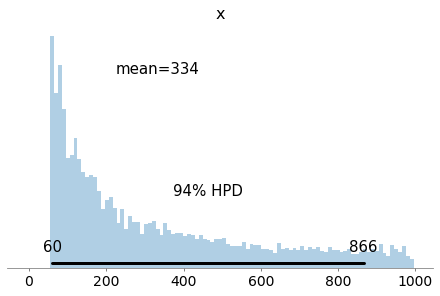

In [8]:
ax = az.plot_posterior(trace_m_3_2['ntrains'], point_estimate='mean', bins=np.linspace(-1, 1001, 100))

In [9]:
# Changing the width of the prior
results_m_3_3_1 = []
for upper_bound in (500, 1000, 2000):
    with m_3_2:
        upper.set_value(upper_bound)
        _trace_m_3_3 = pm.sample(10000, progressbar=False)
    results_m_3_3_1.append((upper_bound, _trace_m_3_3['ntrains'].mean()))

Sequential sampling (2 chains in 1 job)
Metropolis: [ntrains]
The number of effective samples is smaller than 10% for some parameters.
Sequential sampling (2 chains in 1 job)
Metropolis: [ntrains]
The number of effective samples is smaller than 10% for some parameters.
Sequential sampling (2 chains in 1 job)
Metropolis: [ntrains]
The number of effective samples is smaller than 10% for some parameters.


In [10]:
for r in results_m_3_3_1: print(r)

(500, 205.4209)
(1000, 338.8854)
(2000, 539.4662)


In [11]:
# Adding more observations
results_m_3_3_2 = []
with m_3_2:
    pm.set_data({'data': [60,30,90]})

for upper_bound in (500, 1000, 2000):
    with m_3_2:
        upper.set_value(upper_bound)
        _trace_m_3_3 = pm.sample(10000, progressbar=False)
    results_m_3_3_2.append((upper_bound, _trace_m_3_3['ntrains'].mean()))

Sequential sampling (2 chains in 1 job)
Metropolis: [ntrains]
The number of effective samples is smaller than 10% for some parameters.
Sequential sampling (2 chains in 1 job)
Metropolis: [ntrains]
The number of effective samples is smaller than 10% for some parameters.
Sequential sampling (2 chains in 1 job)
Metropolis: [ntrains]
The number of effective samples is smaller than 10% for some parameters.


In [12]:
for r in results_m_3_3_2: print(r)

(500, 154.0134)
(1000, 166.1017)
(2000, 161.79345)


In [13]:
# Changing the prior to a power law
with pm.Model() as m_3_4:
    obs = pm.Data('data', [60])
    upper = theano.shared(1000)

    ntrains = pm.DiscreteUniform('ntrains', lower=1, upper=upper)
    pm.Potential('exp', -pm.math.log(ntrains)) # Equivalent to x**-1

    like = pm.DiscreteUniform('like', lower=1, upper=ntrains, observed=obs)
    trace_m_3_4 = pm.sample(10000)

Sequential sampling (2 chains in 1 job)
Metropolis: [ntrains]
100%|██████████| 10500/10500 [00:01<00:00, 7960.68it/s]
The number of effective samples is smaller than 10% for some parameters.


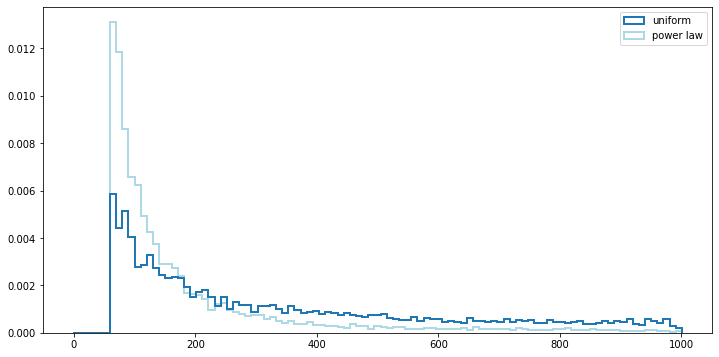

In [14]:
plt.figure(figsize=(12,6))
plt.hist(trace_m_3_2['ntrains'], bins=np.linspace(-1, 1001, 100), histtype='step', density=True, lw=2, color='C0', label='uniform')
plt.hist(trace_m_3_4['ntrains'], bins=np.linspace(-1, 1001, 100), histtype='step', density=True, lw=2, color='lightblue', label='power law', zorder=-1);
plt.legend();

In [15]:
# Checking sensitivity to change in prior width (with 3 datapoints)
results_m_3_4 = []

with m_3_4:
    pm.set_data({'data': [60,30,90]})

for upper_bound in (500, 1000, 2000):
    with m_3_4:
        upper.set_value(upper_bound)
        _trace_m_3_4 = pm.sample(10000, progressbar=False)
    results_m_3_4.append((upper_bound, _trace_m_3_4['ntrains'].mean()))

Sequential sampling (2 chains in 1 job)
Metropolis: [ntrains]
The estimated number of effective samples is smaller than 200 for some parameters.
Sequential sampling (2 chains in 1 job)
Metropolis: [ntrains]
The number of effective samples is smaller than 10% for some parameters.
Sequential sampling (2 chains in 1 job)
Metropolis: [ntrains]
The number of effective samples is smaller than 10% for some parameters.


In [16]:
for r in results_m_3_4: print(r)

(500, 128.07425)
(1000, 131.06685)
(2000, 129.82565)


In [17]:
pm.hpd(_trace_m_3_4['ntrains'], alpha=.05)

array([ 90, 220])